# 10 Years of Jamz: A Genre Classification Challenge
##### by Saba Naqvi

### Introduction
This project aims to classify the genre of a song based on its audio features. With the help of the Spotify API, I read in the information for Jamz, a playlist I've been making for the past 10+ years. It has about 3,500 songs and it would take almost 10 days to listen to all of it. I chose this project because I want to become a data scientist, and I think playing with my own Spotify data (which is very dear to me as a music geek) is a great way to practice several different data science skills -- especially data cleaning and processing (a significant part of this project).

Spotify calculates a diverse set of numeric audio features for a song. These include danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, and tempo. Danceability, for example, "describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable." ([source](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)) I am interested in whether these audio features relate to the genre of the track's artist. 

Spotify associates several genres with the artist of a song, but for the purposes of this project I selected the first genre listed for the first artist of a song (if the song has multiple artists). By combining similar genres (Spotify does like to get very specific) and converting them to integer values, I can use a RandomForestClassifier from the scikit-learn package to train a model. I chose the RandomForestClassifier because it has performed better than its counterparts in CIS 9 lab applications. Regardless, I will also train a GaussianNB model and KNeighborsClassifier to compare the performance between the three.

### Background
This project relies heavily on the [Spotify API](https://developer.spotify.com/documentation/web-api), the [Spotipy library](https://spotipy.readthedocs.io/en/2.22.1/#), and of course the data science workhorses [Pandas](https://pandas.pydata.org/) and [scikit-learn](https://scikit-learn.org/stable/). Songs have been compiled by the author of this project since December 2012. 

### Analysis

Import modules.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 20)

Read Spotify Jamz genres data from .csv file into Pandas DataFrame.

In [106]:
df = pd.read_csv('genres_unprocessed.csv')
df

,Unnamed: 0,track_id,artist,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,5aOQFsNGiKJLbIFXA9427S,Hemant Kumar,"['classic bollywood', 'classic pakistani pop',...",0.428,0.277,4.0,-12.571,1.0,0.0296,0.92800,0.000043,0.1260,0.4380,93.942
1,1,1Y1Zqbk4UsJCTGRNMQSfV3,Wolfgang Amadeus Mozart,"['classical', 'classical era']",0.126,0.139,2.0,-17.939,0.0,0.0377,0.97700,0.519000,0.1200,0.0425,89.382
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,08x3GCYn55rNhJZIZK3INS,Sukanya Purkayastha,[],0.638,0.564,2.0,-8.149,0.0,0.0295,0.06470,0.006960,0.1150,0.3920,80.012
4,4,0OlOqcPE9o9fYiF7ZiGMRX,Rahat Fateh Ali Khan,"['classic pakistani pop', 'filmi', 'modern bol...",0.630,0.569,11.0,-8.435,0.0,0.0372,0.15700,0.000018,0.1060,0.4850,134.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,3466,3gFQOMoUwlR6aUZj81gCzu,Joe Hisaishi,"['anime', 'anime score', 'japanese classical',...",0.410,0.196,0.0,-15.956,1.0,0.0383,0.95300,0.892000,0.0974,0.0622,78.823
3467,3467,3xv229qX6gFRYgplFCTKBl,Xzibit,"['detroit hip hop', 'g funk', 'gangster rap', ...",0.675,0.642,8.0,-10.237,0.0,0.3510,0.85600,0.016400,0.1760,0.5680,92.397
3468,3468,1pwWrPxonLIE12WWu9NzgU,The Black Keys,"['alternative rock', 'blues rock', 'garage roc...",0.647,0.465,6.0,-10.272,0.0,0.0245,0.25800,0.149000,0.1110,0.2430,94.035
3469,3469,2gxnODNtIvc2qdlEVuV1iR,The Black Keys,"['alternative rock', 'blues rock', 'garage roc...",0.528,0.621,11.0,-7.088,0.0,0.0319,0.00719,0.001340,0.0947,0.5410,141.329


In [107]:
df = df.astype({'genre': 'str'})
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.drop(labels=df[df['genre'] == "[]"].index, inplace=True)
df.drop(columns=['Unnamed: 0', 'track_id', 'artist'], inplace=True)
df

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,"['classic bollywood', 'classic pakistani pop',...",0.428,0.277,4.0,-12.571,1.0,0.0296,0.92800,0.000043,0.1260,0.4380,93.942
1,"['classical', 'classical era']",0.126,0.139,2.0,-17.939,0.0,0.0377,0.97700,0.519000,0.1200,0.0425,89.382
3,"['classic pakistani pop', 'filmi', 'modern bol...",0.630,0.569,11.0,-8.435,0.0,0.0372,0.15700,0.000018,0.1060,0.4850,134.203
4,"['desi pop', 'filmi', 'modern bollywood', 'sufi']",0.750,0.402,10.0,-9.748,1.0,0.0540,0.38600,0.000000,0.1340,0.7500,119.833
5,"['album rock', 'blues rock', 'classic rock', '...",0.444,0.721,0.0,-6.337,1.0,0.0261,0.22500,0.002110,0.2420,0.7850,78.453
...,...,...,...,...,...,...,...,...,...,...,...,...
3452,"['anime', 'anime score', 'japanese classical',...",0.410,0.196,0.0,-15.956,1.0,0.0383,0.95300,0.892000,0.0974,0.0622,78.823
3453,"['detroit hip hop', 'g funk', 'gangster rap', ...",0.675,0.642,8.0,-10.237,0.0,0.3510,0.85600,0.016400,0.1760,0.5680,92.397
3454,"['alternative rock', 'blues rock', 'garage roc...",0.647,0.465,6.0,-10.272,0.0,0.0245,0.25800,0.149000,0.1110,0.2430,94.035
3455,"['alternative rock', 'blues rock', 'garage roc...",0.528,0.621,11.0,-7.088,0.0,0.0319,0.00719,0.001340,0.0947,0.5410,141.329


Check for null values.

In [108]:
df.isna().any()

genre               False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
dtype: bool

Here, I condense the massive variety of genres into 8 overarching ones: desi, rock, hip hop, classical, pop, electronic, folk, and jazz. I did this after poring over the CSV source file for quite some time, making sure that each genre was a good descriptor for an artist's music. My original plan was to just use the first listed genre returned by the API, but I found that not all of those first genres made much sense. There was no way I could have converted tags like "permanent wave" and "mellow gold" into normal everyday genres like rock and pop. 

In [109]:
df.replace(to_replace=r'(.*)(?:filmi|bollywood|desi|pakistani)(.*)', value='desi', regex=True, inplace=True)
df.replace(to_replace=r'(.*)(?:rock|permanent wave|punk)(.*)', value='rock', regex=True, inplace=True)
df.replace(to_replace=r'(.*)(?:rap|hip hop|g funk)(.*)', value='hip hop', regex=True, inplace=True)
df.replace(to_replace=r'(.*)(?:classical|orchestral)(.*)', value='classical', regex=True, inplace=True)
df.replace(to_replace=r'(.*)pop(.*)', value='pop', regex=True, inplace=True)
df.replace(to_replace=r'(.*)(?:electro|tronic)(.*)', value='electronic', regex=True, inplace=True)
df.replace(to_replace=r'(.*)folk(.*)', value='folk', regex=True, inplace=True)
df.replace(to_replace=r'(.*)jazz(.*)', value='jazz', regex=True, inplace=True)

The 8 condensed genres represent 92% of the original dataset. There may be elements of these genres in the 8% leftover, but it won't make a dramatic difference in the size of the dataset. I chose to discard them and reset the index.

In [110]:
df['genre'].value_counts().head(8).sum() / df.shape[0] * 100

92.03199052132702

In [111]:
clean_genres = ['desi', 'rock', 'hip hop', 'classical', 'pop', 'electronic', 'folk', 'jazz']
df = df.loc[df['genre'].isin(clean_genres)]
df.reset_index(inplace=True, drop=True)
df.shape

(3107, 12)

Check datatypes of columns to see if anything needs to be changed. The genre column will need to be converted into a numeric value.

In [112]:
df.dtypes

genre                object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

There are 8 genres in the dataset, converted to a range of 0 - 7 since the classification models can't process text data. The names are listed first as a reminder of which number corresponds to which genre.

In [113]:
df['genre'].value_counts().head(8)

rock          1774
pop            497
hip hop        462
desi           180
electronic      87
classical       43
jazz            40
folk            24
Name: genre, dtype: int64

In [114]:
df = df.astype({'genre': 'category'})
df['genre'] = df['genre'].cat.codes
df['genre'].value_counts()

7    1774
6     497
4     462
1     180
2      87
0      43
5      40
3      24
Name: genre, dtype: int64

Create the X and y datasets, given that we want to predict genre based on the audio features.

In [115]:
X = df.drop(columns='genre')
y = df['genre']
display(X, y)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.428,0.277,4.0,-12.571,1.0,0.0296,0.92800,0.000043,0.1260,0.4380,93.942
1,0.126,0.139,2.0,-17.939,0.0,0.0377,0.97700,0.519000,0.1200,0.0425,89.382
2,0.630,0.569,11.0,-8.435,0.0,0.0372,0.15700,0.000018,0.1060,0.4850,134.203
3,0.750,0.402,10.0,-9.748,1.0,0.0540,0.38600,0.000000,0.1340,0.7500,119.833
4,0.444,0.721,0.0,-6.337,1.0,0.0261,0.22500,0.002110,0.2420,0.7850,78.453
...,...,...,...,...,...,...,...,...,...,...,...
3102,0.828,0.568,7.0,-12.780,1.0,0.0997,0.02390,0.000007,0.1020,0.6590,99.993
3103,0.410,0.196,0.0,-15.956,1.0,0.0383,0.95300,0.892000,0.0974,0.0622,78.823
3104,0.675,0.642,8.0,-10.237,0.0,0.3510,0.85600,0.016400,0.1760,0.5680,92.397
3105,0.647,0.465,6.0,-10.272,0.0,0.0245,0.25800,0.149000,0.1110,0.2430,94.035


0       1
1       0
2       1
3       1
4       7
       ..
3102    1
3103    0
3104    4
3105    7
3106    7
Name: genre, Length: 3107, dtype: int8

Determine if any of the features can be removed because they don't have correlation with genre. I anticipated this to be rather bad given that I am using my own personal data and not a dataset that has been designated for machine learning. There is definitely no clear correlation anywhere, though there are still some interesting insights to draw here. For example, jazz music (5) seems to be either not very acoustic to quite acoustic -- the middle range is pretty empty. Classical music (0) is, as expected, not so speechy but very instrumental.

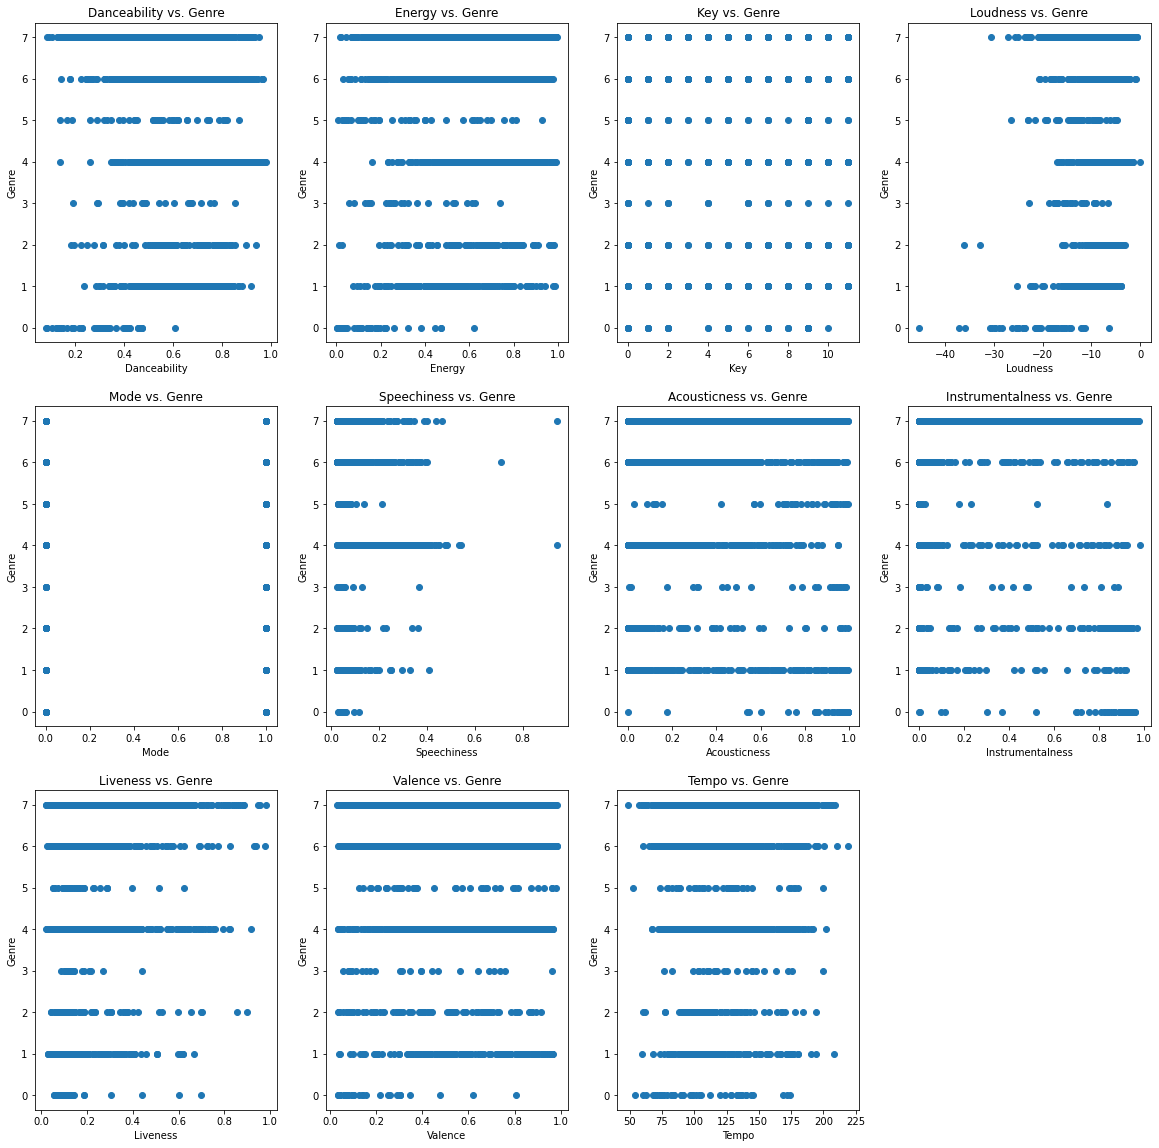

In [116]:
plt.figure(figsize=(20, 20))
plt_number = 1
for X_feature in X.columns:
    plt.subplot(3, 4, plt_number)
    plt.title(f"{X_feature.title()} vs. Genre")
    plt.ylabel('Genre')
    plt.xlabel(X_feature.title())
    plt.scatter(X[X_feature], y)
    plt_number += 1

In order to have some data to actually train a model on (albeit data with little correlation), I only removed the worst offenders -- the categorical variables of key and mode. I redid the scatter plots to get a closer look at the remaining features.

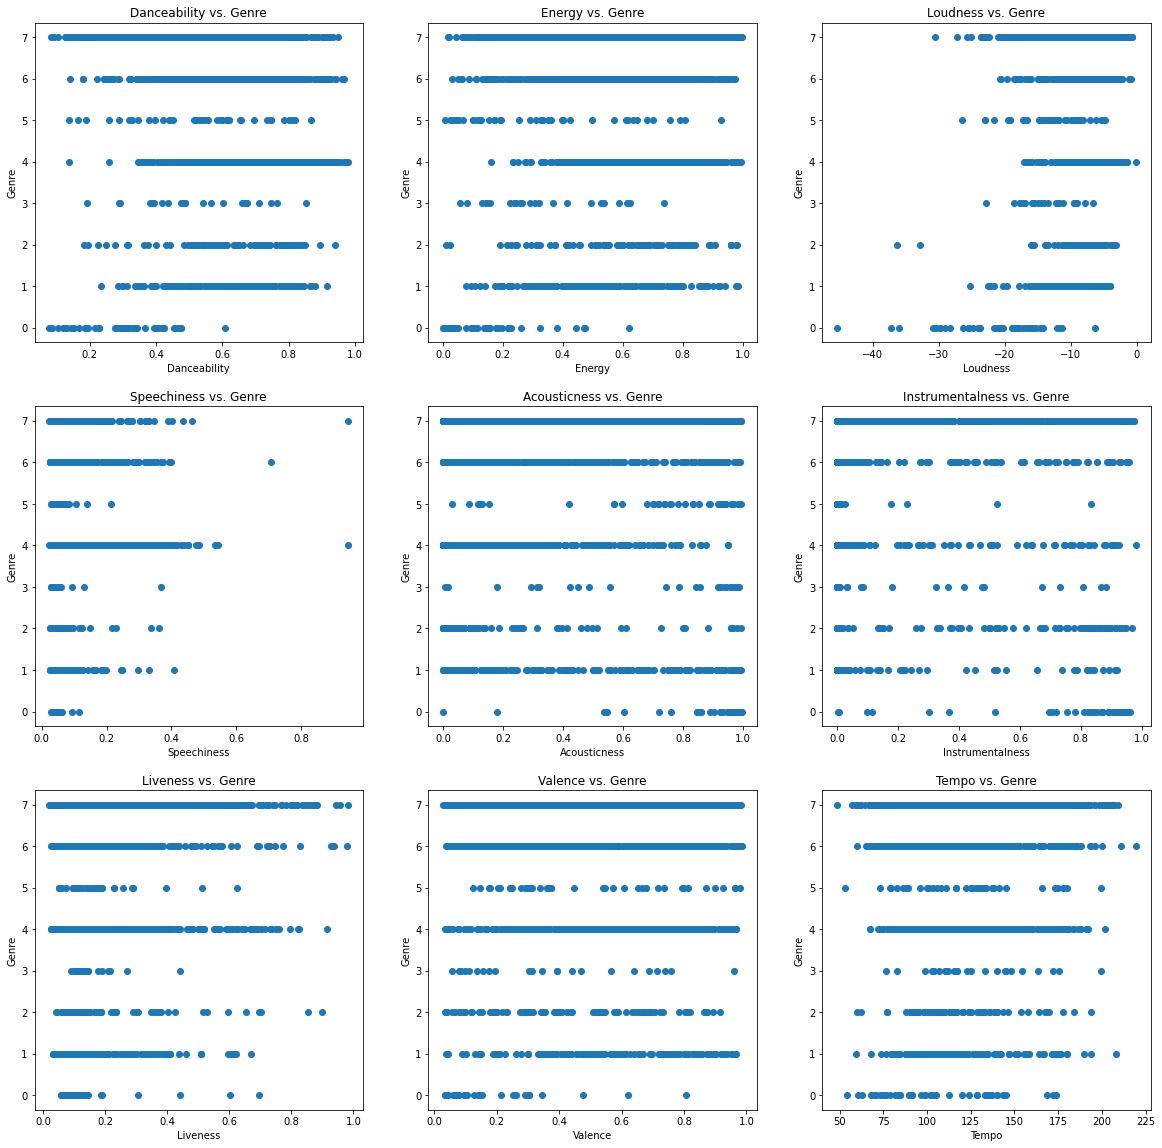

In [117]:
X.drop(columns=['key', 'mode'], inplace=True)
plt.figure(figsize=(20, 20))
plt_number = 1
for X_feature in X.columns:
    plt.subplot(3, 3, plt_number)
    plt.title(f"{X_feature.title()} vs. Genre")
    plt.ylabel('Genre')
    plt.xlabel(X_feature.title())
    plt.scatter(X[X_feature], y)
    plt_number += 1

Create the training and testing X and y datasets and verify that the shape is consistent between them. 

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('X_train Shape:')
display(X_train.shape)
print('X_test Shape:')
display(X_test.shape)
print('y_train Shape:')
display(y_train.shape)
print('y_test Shape:')
display(y_test.shape)

X_train Shape:


(2330, 9)

X_test Shape:


(777, 9)

y_train Shape:


(2330,)

y_test Shape:


(777,)

The Random Forest Classifier model is tried first because it performed better than its counterparts on Lab 3A. It doesn't perform the best at an accuracy score of ~0.65 and an F1 score of ~.6. However, I'm still happy it gets the genre right more than half the time. 

In [119]:
print('Random Forest Classifier:')
classifier = RandomForestClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(y_test, y_pred)}')

Random Forest Classifier:
Accuracy Score: 0.6486486486486487
F1 Score: 0.5988974023787489
Confusion Matrix: 
[[  8   0   0   0   0   0   0   4]
 [  0   4   0   0   5   1   1  31]
 [  1   1   3   0   3   0   1  10]
 [  0   1   0   0   0   0   0   3]
 [  0   1   0   0  62   0  16  39]
 [  2   1   0   0   0   1   1  10]
 [  1   5   0   0  27   0  25  74]
 [  1   3   0   0  12   0  18 401]]


I tried other models to see if they might perform better than the Random Forest Classifier. The Naive Bayes Classifier performed only slightly worse than the first model, but the KNN model seriously tanked at scores below 40%.

In [120]:
print('Naive Bayes Classifier:')
model = GaussianNB()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(y_test, y_pred)}')

Naive Bayes Classifier:
Accuracy Score: 0.5572715572715573
F1 Score: 0.5332356954941717
Confusion Matrix: 
[[  9   0   1   2   0   0   0   0]
 [  2   0   0   4   5  10   3  18]
 [  1   1   7   1   3   0   0   6]
 [  1   0   0   1   0   0   1   1]
 [  0   1   4   2  62   1  10  38]
 [  5   1   0   0   0   3   1   5]
 [  3   3   4   5  33   9   9  66]
 [  4   4   9  18  24  26   8 342]]


In [121]:
print('K Nearest Neighbors Classifier:')
classifier = KNeighborsClassifier(n_neighbors=2)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(y_test, y_pred)}')

K Nearest Neighbors Classifier:
Accuracy Score: 0.36293436293436293
F1 Score: 0.3865103080227439
Confusion Matrix: 
[[  6   2   0   0   1   0   1   2]
 [  1  10   2   0   5   0   7  17]
 [  1   2   2   0   5   0   4   5]
 [  0   2   0   0   0   0   0   2]
 [  1   8   5   0  39   0  23  42]
 [  3   2   1   0   1   0   1   7]
 [  0  12   6   1  42   2  30  39]
 [  9  38  18   3  90   5  77 195]]


In order to dig deeper into the specifics of the RandomForestClassifier, I did some research and implemented hyperparameter tuning. First, I reran the classifier normally. I then created a parameter grid with different parameter values the GridSearchCV could parse through to find the best possible one. When I ran another model with the tuned parameters, the classifier actually performed slightly worse. I conclude that the default parameters set by the classifier were likely the best -- they did not need to be tweaked,

In [122]:
print('Random Forest Classifier with Default Parameters:')
classifier = RandomForestClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(y_test, y_pred)}')

Random Forest Classifier with Default Parameters:
Accuracy Score: 0.6473616473616474
F1 Score: 0.5986263236388156
Confusion Matrix: 
[[  8   0   0   0   0   0   0   4]
 [  0   5   0   0   4   0   3  30]
 [  1   1   2   0   3   0   1  11]
 [  0   1   0   0   0   0   1   2]
 [  0   3   0   0  60   0  19  36]
 [  2   2   0   0   1   1   2   7]
 [  1   4   1   0  28   0  24  74]
 [  1   4   0   0   7   0  20 403]]


In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

In [ ]:
print('Random Forest Classifier with Tuned Parameters:')
model_grid = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=25)
model_grid.fit(X_train, y_train)
y_pred = model_grid.predict(X_test)
print(f'Accuracy Score: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred, average="weighted")}')
print(f'Confusion Matrix: \n{metrics.confusion_matrix(y_test, y_pred)}')

### Conclusion
Given that the data for this project was imported from the Spotify API, it wasn't perfect. The huge variety of genres was very daunting, and I had to make some personal choices on which genres to combine and which to discard. Some songs that had genres too esoteric that only occured once got removed. Having more consistency and accurately labeled artist genres may have resulted in higher correlation between the audio features and the genre. However, it's also plausible that the audio features of a song don't have any bearing on its genre -- at least not all of them. In order to improve the result, I could work on gathering a more consistent dataset (for example, the top songs of my top 50 artists). It would also be interesting to run a K-Means Clustering model on this data, since a peek at a pair plot of the features did show some correlation between them. For example, loudness and energy definitely have a positive correlation. 

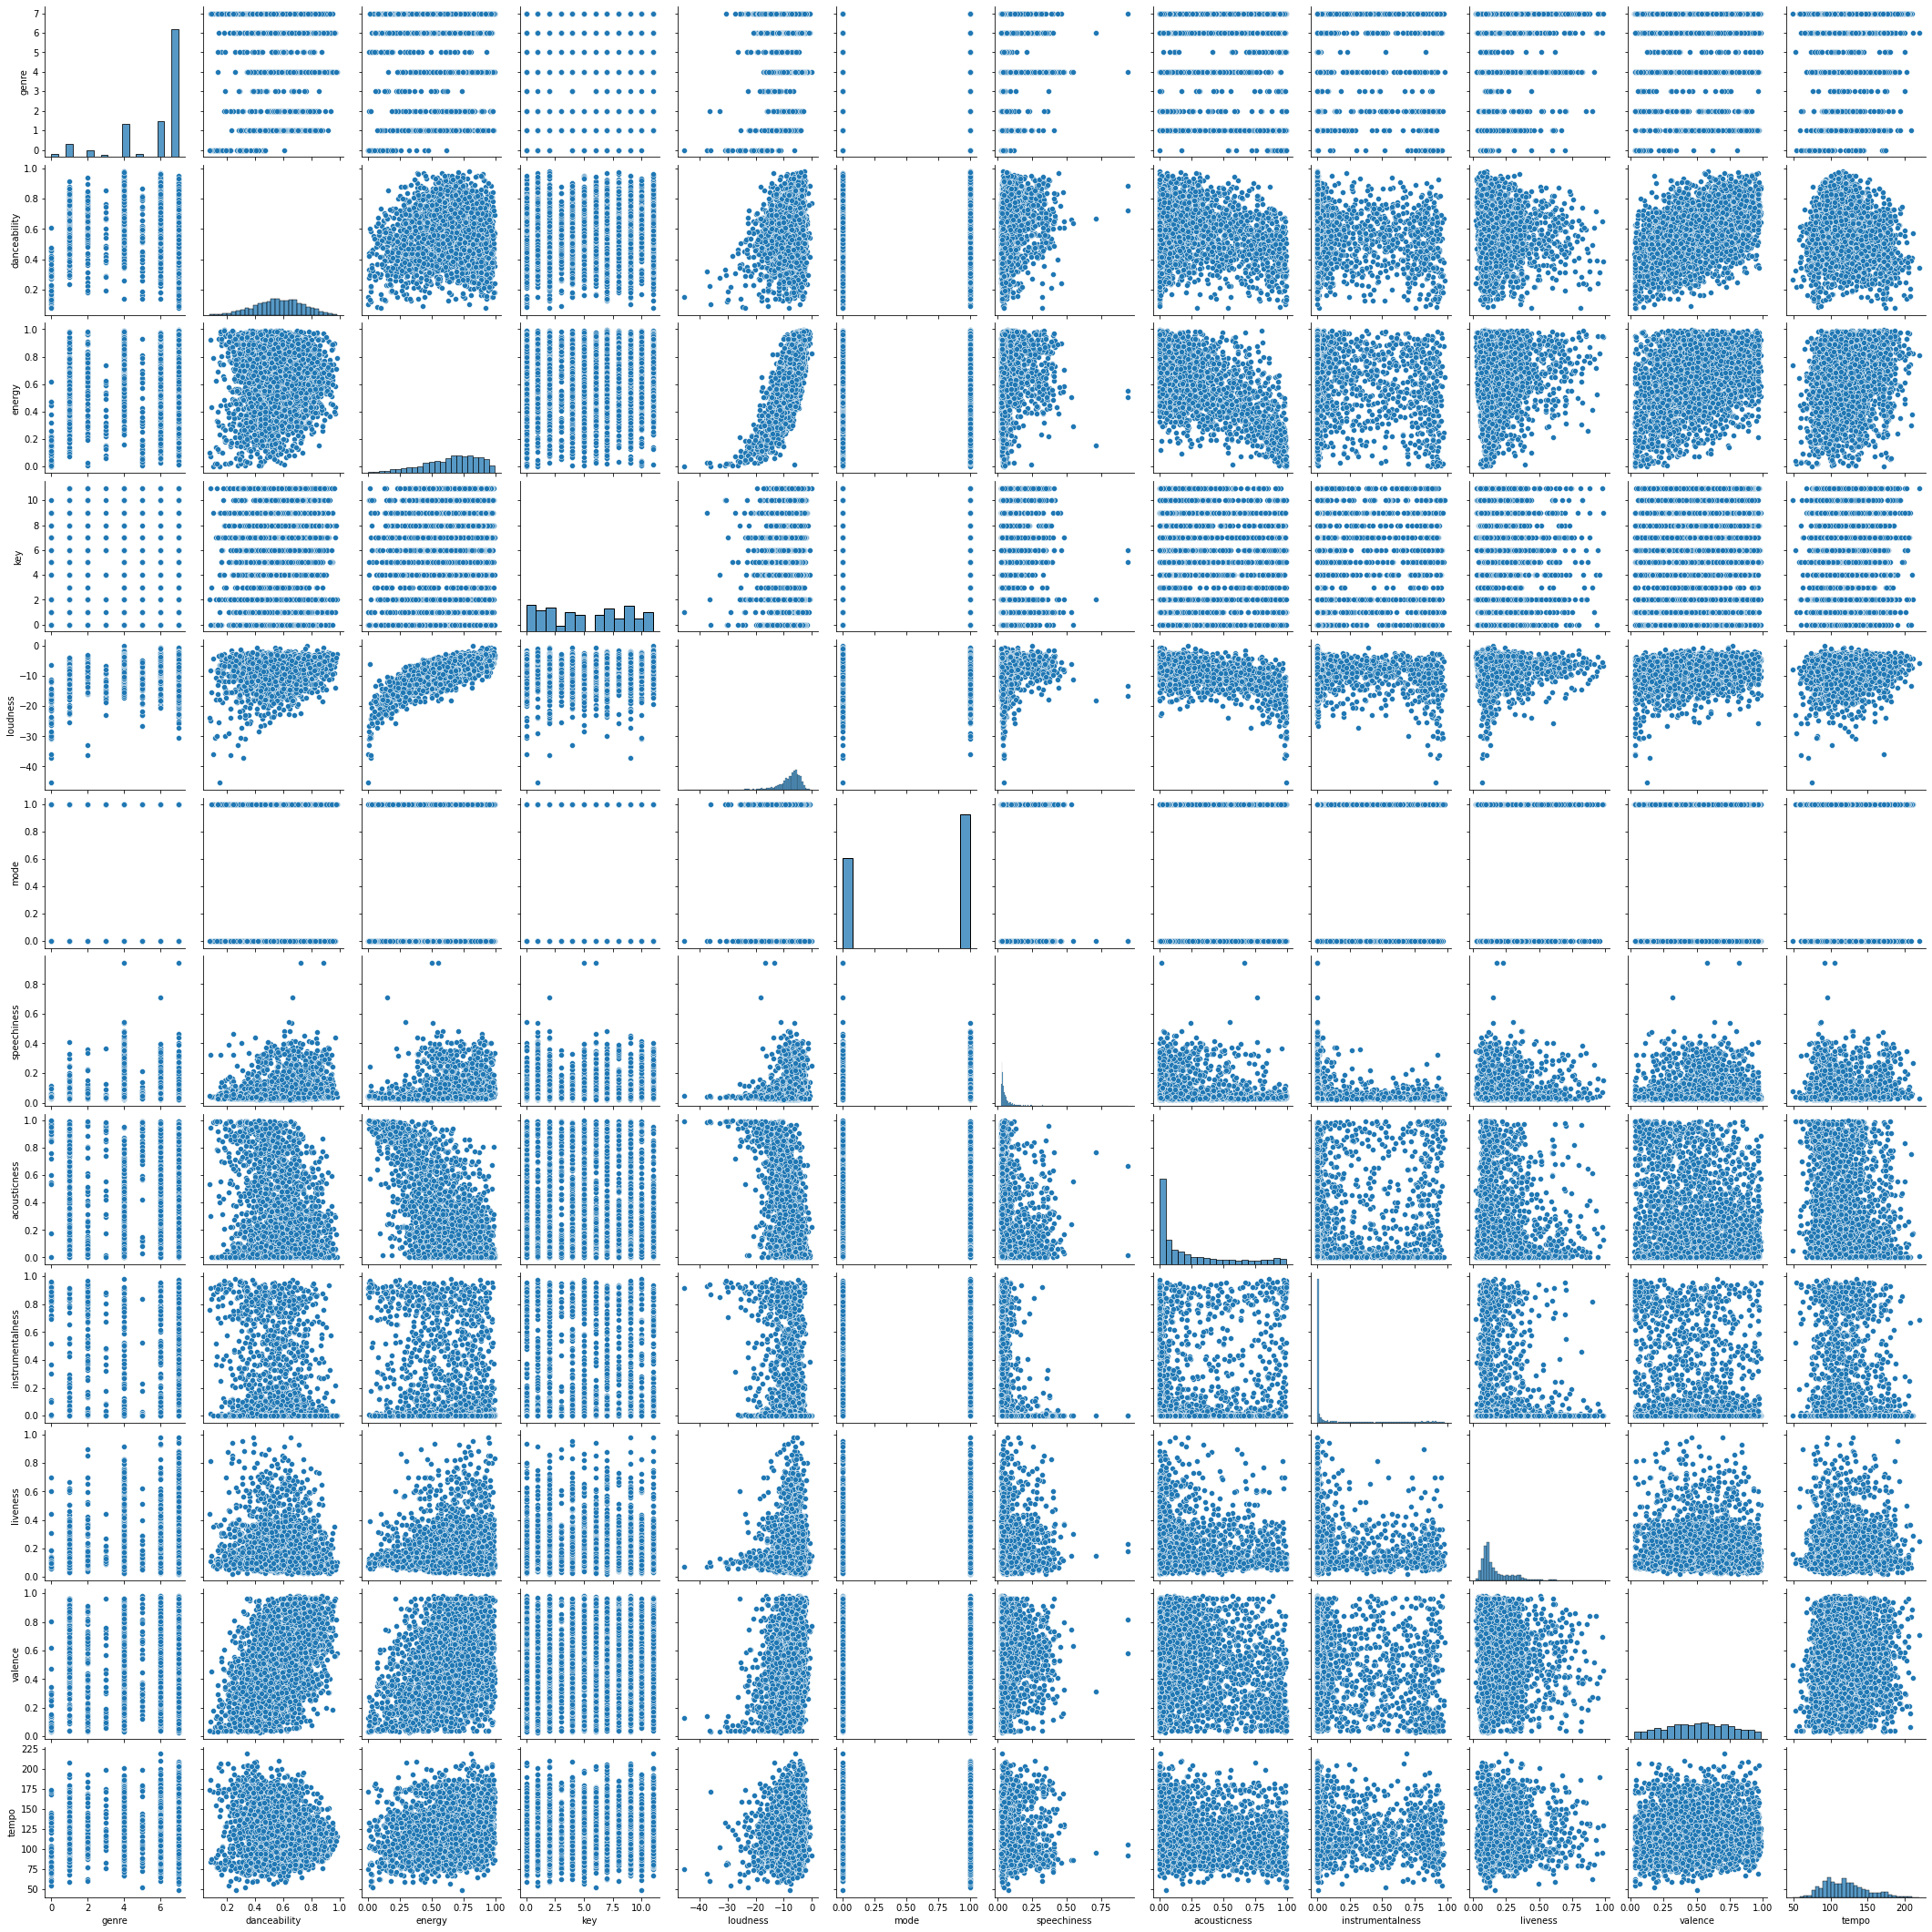

In [104]:
sns.pairplot(df)